In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
import scipy as scp
import pandas as pd
import copy as cp
from tqdm import tqdm 

sns.set_theme(style="darkgrid",context='talk', font_scale=1.1)
%matplotlib inline

In [2]:
import numpy as np
from scipy.signal import correlate2d

In [3]:
fec_pars = {'A': {'OP50': [22.65, 68.45, 57.05, 33.4,  4.97], 'Novo': [11.66, 62.53, 47.13, 13.94,  0.72]},
            'C': {'OP50': [19.8 , 60.3 , 43.02, 19.9,  6.6], 'Novo': [16.88, 80.77, 77.7 , 16.28,  1.4]}}

mf_prob = {'A': {'OP50': 0.11, 'Novo': 0.83}, 'C': {'OP50': 1.0, 'Novo': 1.0}}

In [29]:
class Population(object):
    
    def __init__(self, n0, consumption=0.0, r0=1000, diet='OP50', α=False):
        self.pop = n0
        self.resource = r0
        self.α = α
        self.diet = diet
        self.consumption = consumption
        self.f_mat_A = self.gen_fec_matrix('A', diet, 0.0415)
        self.f_mat_C = self.gen_fec_matrix('C', diet, 0.0415)
        self.comb_f_mat = np.block([[self.f_mat_A, np.zeros((10,10))],
                                    [np.zeros((10,10)), self.f_mat_C]])
        
    @property
    def u_mat(self):
        u_mat_A = self.generate_matrix(self.resource, self.diet, 'A')
        u_mat_C = self.generate_matrix(self.resource, self.diet, 'C')
        return (u_mat_A, u_mat_C)
    
    @property
    def comb_u_mat(self):
        u_A, u_C = self.u_mat
        if not self.α:
            comb_u_mat = np.block([[u_A, np.zeros((10,10))],
                                   [np.zeros((10,10)), u_C]])
        else:
            # A killing C
            ll_mat = np.zeros((10,10))
            ll_mat[1][3] = -self.α * mf_prob['A'][self.diet] * self.pop[1][0] 
            ll_mat[1][4] = -self.α * mf_prob['A'][self.diet] * self.pop[1][0]
            ll_mat[1][5] = -self.α * mf_prob['A'][self.diet] * self.pop[1][0]
            ll_mat[1][6] = -self.α * mf_prob['A'][self.diet] * self.pop[1][0]
            ll_mat[1][7] = -self.α * mf_prob['A'][self.diet] * self.pop[1][0]
            ll_mat[1][8] = -self.α * mf_prob['A'][self.diet] * self.pop[1][0]
            ll_mat[1][9] = -self.α * mf_prob['A'][self.diet] * self.pop[1][0]
            # dauer
            ll_mat[2][3] = -self.α * mf_prob['A'][self.diet] * self.pop[2][0] 
            ll_mat[2][4] = -self.α * mf_prob['A'][self.diet] * self.pop[2][0]
            ll_mat[2][5] = -self.α * mf_prob['A'][self.diet] * self.pop[2][0]
            ll_mat[2][6] = -self.α * mf_prob['A'][self.diet] * self.pop[2][0]
            ll_mat[2][7] = -self.α * mf_prob['A'][self.diet] * self.pop[2][0]
            ll_mat[2][8] = -self.α * mf_prob['A'][self.diet] * self.pop[2][0]
            ll_mat[2][9] = -self.α * mf_prob['A'][self.diet] * self.pop[2][0]
            # C killing A
            ur_mat = np.zeros((10,10))
            ur_mat[1][3] = -self.α * mf_prob['C'][self.diet] * self.pop[11][0]
            ur_mat[1][4] = -self.α * mf_prob['C'][self.diet] * self.pop[11][0]
            ur_mat[1][5] = -self.α * mf_prob['C'][self.diet] * self.pop[11][0]
            ur_mat[1][6] = -self.α * mf_prob['C'][self.diet] * self.pop[11][0]
            ur_mat[1][7] = -self.α * mf_prob['C'][self.diet] * self.pop[11][0]
            ur_mat[1][8] = -self.α * mf_prob['C'][self.diet] * self.pop[11][0]
            ur_mat[1][9] = -self.α * mf_prob['C'][self.diet] * self.pop[11][0]
            #dauer
            ur_mat[2][3] = -self.α * mf_prob['C'][self.diet] * self.pop[12][0]
            ur_mat[2][4] = -self.α * mf_prob['C'][self.diet] * self.pop[12][0]
            ur_mat[2][5] = -self.α * mf_prob['C'][self.diet] * self.pop[12][0]
            ur_mat[2][6] = -self.α * mf_prob['C'][self.diet] * self.pop[12][0]
            ur_mat[2][7] = -self.α * mf_prob['C'][self.diet] * self.pop[12][0]
            ur_mat[2][8] = -self.α * mf_prob['C'][self.diet] * self.pop[12][0]
            ur_mat[2][9] = -self.α * mf_prob['C'][self.diet] * self.pop[12][0]
            comb_u_mat = np.block([[u_A, ur_mat],
                                  [ll_mat, u_C]])
        return comb_u_mat
            
    @property
    def fund_mat(self):
        u_A, u_C = self.u_mat
        return (np.linalg.inv(np.identity(10) - u_A), np.linalg.inv(np.identity(10) - u_C))
    
    @property
    def growth_rate(self):
        fund_m = self.fund_mat
        return (np.linalg.eig(self.f_mat_A*fund_m[0])[0][0], np.linalg.eig(self.f_mat_C*fund_m[0])[0][0])
        
    @staticmethod
    def generate_matrix(r, diet, strain, r_min=100):
        U = np.identity(10) * 0
        γ_JE  = lambda r: 0.0415 if r > r_min else 0.0
        γ_DJ = lambda r: 0.0415 if r < r_min else 0.0
        γ_YD = lambda r: 0.0415 if r > r_min else 0.0

        γ_YJ = lambda r: 0.0415 if r > r_min else 0.0
        if (diet=='Novo' and strain == 'C'):
            γ_RAY = 0.2
        else:
            γ_RAY = 0.1
        γ_RR = 0.0415
        γ_OR = 0.0415
        δ_E = lambda r: 1 if r > r_min else 0.9
        δ_J = lambda r: 1 if r > r_min else 0.9
        δ_Y = lambda r: 1 if r > r_min else 0.9
        δ_RA = lambda r: 1 if r > r_min else 0.9
        δ_OA = lambda r: 0.995 if r > r_min else 0.9
        δ_D = 1
        U[0][0] = δ_E(r) * (1 - γ_JE(r))
        # juvenile ra(r)tes
        U[1][0] = δ_E(r) * γ_JE(r)
        U[1][1] = δ_J(r) * (1 - γ_YJ(r)) * (1 - γ_DJ(r))
        # dauer rates
        U[2][1] = δ_J(r) * γ_DJ(r)
        U[2][2] = δ_D * (1 - γ_YD(r))
        # young adults
        U[3][1] = δ_J(r) * γ_YJ(r)
        U[3][2] = δ_D * γ_YD(r)
        U[3][3] = δ_Y(r) * (1 - γ_RAY)
        # reproducing adults
        U[4][3] = δ_Y(r) * γ_RAY
        U[4][4] = δ_RA(r) * (1 - γ_RR)
        U[5][4] = δ_RA(r) * γ_RR
        U[5][5] = δ_RA(r) * (1 - γ_RR)
        U[6][5] = δ_RA(r) * γ_RR
        U[6][6] = δ_RA(r) * (1 - γ_RR)
        U[7][6] = δ_RA(r) * γ_RR
        U[7][7] = δ_RA(r) * (1 - γ_RR)
        U[8][7] = δ_RA(r) * γ_RR
        U[8][8] = δ_RA(r) * (1 - γ_OR)
        # old adults
        U[9][8] = δ_RA(r) * γ_OR
        U[9][9] = δ_OA(r)

        return np.matrix(U)
    
    @staticmethod
    def gen_fec_matrix(strain, food_type, rate):
        """Generate fecundity matrix.

        Args:
            strain (str): A (RSC017) or C (RS5405)
            food_type (str): The bacterial diet (Novo or OP50)

        Returns:
            numpy matrix: fecundity values for each breeding developmental stage.
        """
        F = np.identity(10) * 0
        count = 0
        for i in np.arange(4, 9, 1):
            F[0][i] = rate*fec_pars[strain][food_type][count]
            count += 1
        return np.matrix(F)
    
    def take_a_step(self):
        n = np.array(np.matmul(self.comb_u_mat + self.comb_f_mat, self.pop))
        self.pop = n.clip(min=0)
        if self.consumption > 0.0:
            total_conusmers = self.pop[1][0] + np.sum(self.pop[3:10]) + self.pop[11][0] + np.sum(self.pop[13:20])
            self.resource -= self.consumption * total_conusmers
            if self.resource < 0:
                self.resource = 0
            
            
class MetaPopulation(object):
    
    kernel = np.array([[0, 1, 0],
                       [1,-4, 1],
                       [0, 1, 0]])
    
    def __init__(self, dim, pred_rate, c, r_rate=0):
        self.dim = dim
        self.pred_rate = pred_rate
        self.cons_rate = c
        self.r_rate = r_rate
        self.index = [(i,j) for i in range(dim) for j in range(dim)]
        
    def set_diet_comp(self, style):
        if style == 'OP50':
            self.diet_comp = {i:'OP50' for i in self.index}
        elif style == 'Novo':
            self.diet_comp = {i:'Novo' for i in self.index}
        
    def fill_pop(self):
        n0_empty = np.array([[0],  [0], [0], [0], [0], [0], [0], [0], [0], [0], [0],  [0], [0], [0], [0], [0], [0], [0], [0], [0]])
        self.metapop = {i:Population(n0_empty, consumption=self.cons_rate, α=self.pred_rate) for i in self.index}
        
    def add_pop(self, loc, strain):
        if strain == 'A':
            n0_A = np.array([[0], [50], [0], [0], [0], [0], [0], [0], [0], [0], [0],  [0], [0], [0], [0], [0], [0], [0], [0], [0]])
            self.metapop[loc] = Population(n0_A, consumption=self.cons_rate, α=self.pred_rate, diet=self.diet_comp[loc])
        else:
            n0_C = np.array([[0],  [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [50], [0], [0], [0], [0], [0], [0], [0], [0]])
            self.metapop[loc] = Population(n0_C, consumption=self.cons_rate, α=self.pred_rate, diet=self.diet_comp[loc])
            
    def reset_food(self, r0=1000):
        for i in self.index:
            self.metapop[i].resource = r0

    @property
    def daur_dist(self):
        dist_A = np.zeros((self.dim, self.dim))
        dist_C = np.zeros((self.dim, self.dim))
        for i in self.index:
            dist_A[i[0]][i[1]] = self.metapop[i].pop[2][0]
            dist_C[i[0]][i[1]] = self.metapop[i].pop[12][0]
        return dist_A, dist_C
    
    @property
    def r_dist(self):
        r_patt = np.zeros((self.dim, self.dim))
        for i in self.index:
            r_patt[i[0]][i[1]] = self.metapop[i].resource
        return r_patt
    
    @property
    def ra_dist(self):
        dist_A = np.zeros((self.dim, self.dim))
        dist_C = np.zeros((self.dim, self.dim))
        for i in self.index:
            dist_A[i[0]][i[1]] = np.sum(self.metapop[i].pop[4:9])
            dist_C[i[0]][i[1]] = np.sum(self.metapop[i].pop[14:19])
        return dist_A, dist_C
    
    def diffuse_dauer(self):
        a, c = self.daur_dist
        total = np.sum(a) + np.sum(c)
        if total >= 0:
            total_a = np.sum(a)
            total_c = np.sum(c)
            if total_a > 0:
                f_a = np.divide(a, total)
                diff_state_a = self.r_rate * correlate2d(f_a, self.kernel, mode='same', boundary='symm')
                f_a += diff_state_a
                f_a = total_a * f_a
                for i in self.index:
                    self.metapop[i].pop[2][0]  = f_a[i[0]][i[1]]
            if total_c > 0:
                f_c = np.divide(c, total)
                diff_state_c = self.r_rate * correlate2d(f_c, self.kernel, mode='same', boundary='symm')
                f_c += diff_state_c
                f_c = total_c * f_c
                for i in self.index:
                    self.metapop[i].pop[12][0] = f_c[i[0]][i[1]]
                    
#     def diffuse_dauer_r(self):
#         a, c = self.daur_dist
#         total = np.sum(a) + np.sum(c)
#         if total >= 0:
#             r_dist_n = 1 - np.divide(self.r_dist, 1000.)
#             diff_state_a = self.r_rate * correlate2d(r_dist_n, self.kernel, mode='same', boundary='symm')

    def simulate_pops_one_step(self):
        for i in self.index:
            self.metapop[i].take_a_step()

In [128]:
n0 = np.array([[0], [50], [0], [0], [0], [0], [0], [0], [0], [0], [0], [50], [0], [0], [0], [0], [0], [0], [0], [0]])
pop = Population(n0, consumption=0.01, diet='OP50', α=0.02)
n_list = []
r_list = []
for i in range(100):
    n_list.append(pop.pop)
    r_list.append(pop.resource)
    pop.take_a_step()

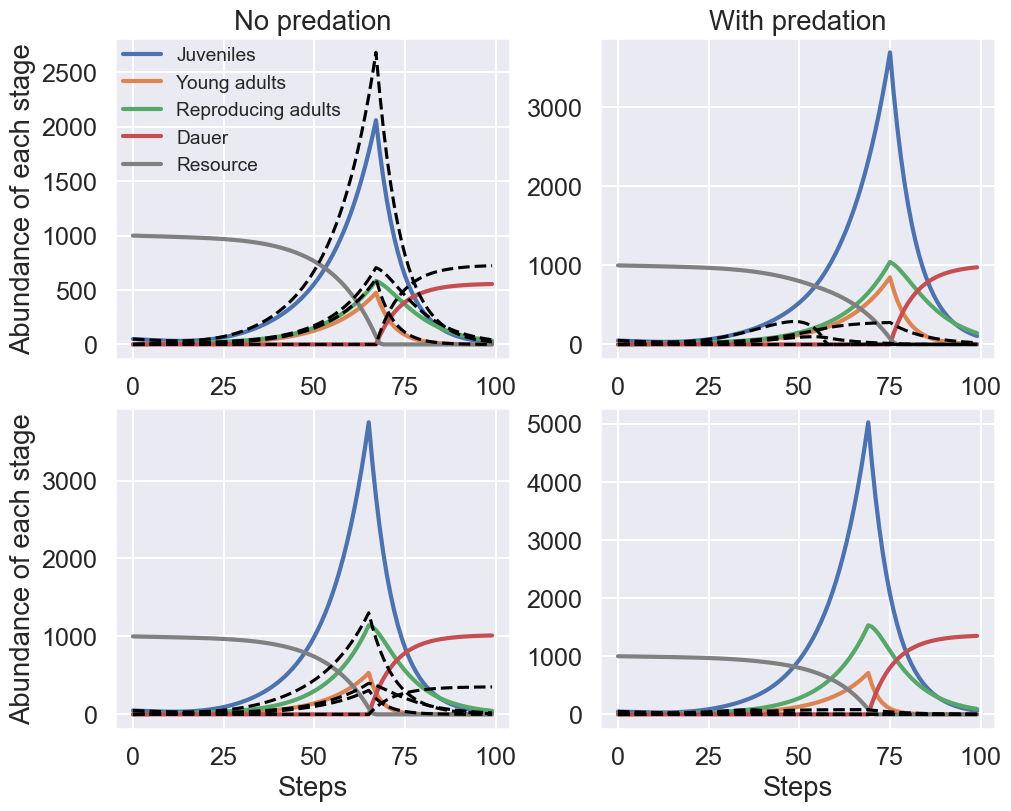

In [258]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(10, 8),
    constrained_layout=True)

axes = axes.flatten()

n0 = np.array([[0], [50], [0], [0], [0], [0], [0], [0], [0], [0], [0], [50], [0], [0], [0], [0], [0], [0], [0], [0]])
pop = Population(n0, consumption=0.01, diet='OP50', α=0.0)
n_list = []
r_list = []
for i in range(100):
    n_list.append(pop.pop)
    r_list.append(pop.resource)
    pop.take_a_step()

axes[0].plot([m[11][0] for m in n_list], lw=3, label='Juveniles')
axes[0].plot([m[13][0] for m in n_list], lw=3, label='Young adults')
axes[0].plot([np.sum(m[14:19]) for m in n_list], lw=3, label='Reproducing adults')
axes[0].plot([m[12][0] for m in n_list], lw=3, label='Dauer')
axes[0].plot(r_list, lw=3, color='gray', label='Resource')


axes[0].plot([m[1][0] for m in n_list], color='black', ls='--')
axes[0].plot([m[3][0] for m in n_list], color='black', ls='--')
axes[0].plot([np.sum(m[4:9]) for m in n_list],color='black', ls='--')
axes[0].plot([m[2][0] for m in n_list],color='black', ls='--')
axes[0].legend(loc=(0,0.55), frameon=False, fontsize='x-small')

n0 = np.array([[0], [50], [0], [0], [0], [0], [0], [0], [0], [0], [0], [50], [0], [0], [0], [0], [0], [0], [0], [0]])
pop = Population(n0, consumption=0.01, diet='OP50', α=5e-4)
n_list = []
r_list = []
for i in range(100):
    n_list.append(pop.pop)
    r_list.append(pop.resource)
    pop.take_a_step()

axes[1].plot([m[11][0] for m in n_list], lw=3, label='Juveniles')
axes[1].plot([m[13][0] for m in n_list], lw=3, label='Young adults')
axes[1].plot([np.sum(m[14:19]) for m in n_list], lw=3, label='Reproducing adults')
axes[1].plot([m[12][0] for m in n_list], lw=3, label='Dauer')
axes[1].plot(r_list, lw=3, color='gray', label='Resource')
axes[1].plot([m[1][0] for m in n_list], color='black', ls='--')
axes[1].plot([m[3][0] for m in n_list], color='black', ls='--')
axes[1].plot([np.sum(m[4:9]) for m in n_list],color='black', ls='--')
axes[1].plot([m[2][0] for m in n_list],color='black', ls='--')


n0 = np.array([[0], [50], [0], [0], [0], [0], [0], [0], [0], [0], [0], [50], [0], [0], [0], [0], [0], [0], [0], [0]])
pop = Population(n0, consumption=0.01, diet='Novo', α=0.0)
n_list = []
r_list = []
for i in range(100):
    n_list.append(pop.pop)
    r_list.append(pop.resource)
    pop.take_a_step()

axes[2].plot([m[11][0] for m in n_list], lw=3, label='Juveniles')
axes[2].plot([m[13][0] for m in n_list], lw=3, label='Young adults')
axes[2].plot([np.sum(m[14:19]) for m in n_list], lw=3, label='Reproducing adults')
axes[2].plot([m[12][0] for m in n_list], lw=3, label='Dauer')
axes[2].plot(r_list, lw=3, color='gray', label='Resource')
axes[2].plot([m[1][0] for m in n_list], color='black', ls='--')
axes[2].plot([m[3][0] for m in n_list], color='black', ls='--')
axes[2].plot([np.sum(m[4:9]) for m in n_list],color='black', ls='--')
axes[2].plot([m[2][0] for m in n_list],color='black', ls='--')

n0 = np.array([[0], [50], [0], [0], [0], [0], [0], [0], [0], [0], [0], [50], [0], [0], [0], [0], [0], [0], [0], [0]])
pop = Population(n0, consumption=0.01, diet='Novo', α=5e-4)
n_list = []
r_list = []
for i in range(100):
    n_list.append(pop.pop)
    r_list.append(pop.resource)
    pop.take_a_step()

axes[3].plot([m[11][0] for m in n_list], lw=3, label='Juveniles')
axes[3].plot([m[13][0] for m in n_list], lw=3, label='Young adults')
axes[3].plot([np.sum(m[14:19]) for m in n_list], lw=3, label='Reproducing adults')
axes[3].plot([m[12][0] for m in n_list], lw=3, label='Dauer')
axes[3].plot(r_list, lw=3, color='gray', label='Resource')
axes[3].plot([m[1][0] for m in n_list], color='black', ls='--')
axes[3].plot([m[3][0] for m in n_list], color='black', ls='--')
axes[3].plot([np.sum(m[4:9]) for m in n_list],color='black', ls='--')
axes[3].plot([m[2][0] for m in n_list],color='black', ls='--')

# axes[1].bar([1, 2], [[m[2][0] for m in n_list][-1], [m[12][0] for m in n_list][-1]], color=[sns.color_palette()[0] , sns.color_palette()[1]])

# axes[1].set(xticks=[1,2], xticklabels=['', ''])

# axes[1].set(ylabel='Final dauer larvae count')

# axes[0].set(ylabel='Abundance of each stage')

# n0 = np.array([[0], [50], [0], [0], [0], [0], [0], [0], [0], [0], [0], [50], [0], [0], [0], [0], [0], [0], [0], [0]])
# pop = Population(n0, consumption=0.01, diet='Novo', α=0.0)
# n_list = []
# r_list = []
# for i in range(100):
#     n_list.append(pop.pop)
#     r_list.append(pop.resource)
#     pop.take_a_step()

# axes[2].plot([m[1][0] for m in n_list], lw=3, label='Juveniles')
# axes[2].plot([m[3][0] for m in n_list], lw=3, label='Young adults')
# axes[2].plot([np.sum(m[4:9]) for m in n_list], lw=3, label='Reproducing adults')

# axes[2].plot(r_list, lw=3, color='gray', label='Resource')

# axes[2].plot([m[11][0] for m in n_list], color='black', ls='--')
# axes[2].plot([m[13][0] for m in n_list], color='black', ls='--')
# axes[2].plot([np.sum(m[14:19]) for m in n_list],color='black', ls='--')

# axes[3].bar([1, 2], [[m[2][0] for m in n_list][-1], [m[12][0] for m in n_list][-1]], color=[sns.color_palette()[0] , sns.color_palette()[1]])

# axes[3].set(xticks=[1,2], xticklabels=['Strain P', 'Strain NP'])

# axes[3].set(ylabel='Final dauer larvae count')

# axes[2].set(ylabel='Abundance of each stage')


for i in axes[2:]:
    i.set_xlabel('Steps')

for i in [0,2]:
    axes[i].set_ylabel('Abundance of each stage')
    
axes[0].set(title='No predation')

axes[1].set(title='With predation')

plt.savefig('./figures/PopDynamic_with_interaction.pdf', bbox_inches='tight', dpi=300)

In [447]:
metpop = MetaPopulation(20, 0.01, 0.01, r_rate=0.05)

In [453]:
metpop.set_diet_comp('OP50')

In [449]:
metpop.fill_pop()

In [450]:
metpop.add_pop((0,0), 'A')
metpop.add_pop((19,19), 'A')
metpop.add_pop((0,19), 'C')
metpop.add_pop((19,0), 'C')

In [451]:
dist_t = []
dis_a = []
for i in range(500):
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    t1, t2 = metpop.ra_dist
    # f_a = np.sum(t1)/np.sum(t1 + t2)
    dist_t.append((a, b))
    # dis_a.append((f_a, np.sum(t1)))
    dis_a.append((t1, t2))
    metpop.diffuse_dauer()

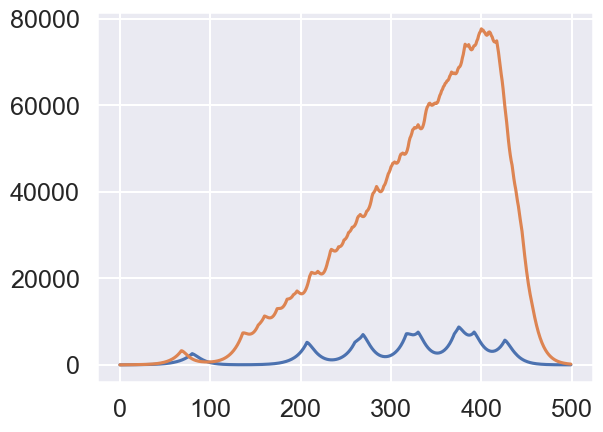

In [452]:
plt.plot([np.sum(i[0]) for i in dis_a])
plt.plot([np.sum(i[1]) for i in dis_a])

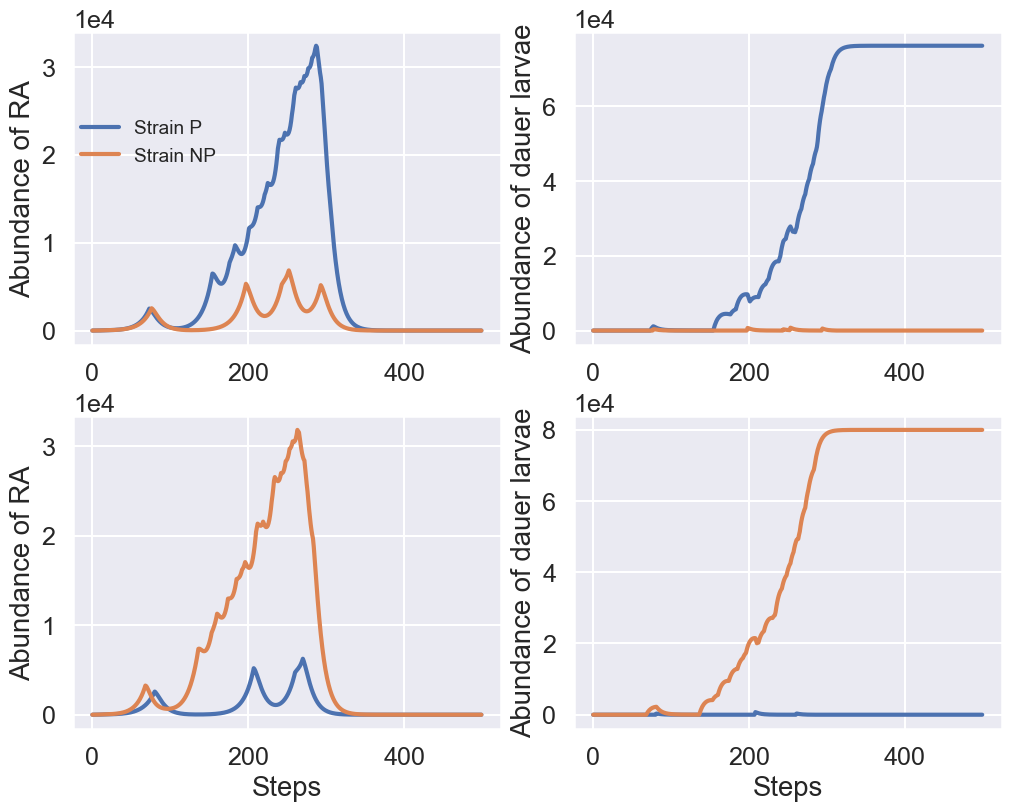

In [469]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(10, 8),
    constrained_layout=True)

axes = axes.flatten()

metpop = MetaPopulation(10, 0.01, 0.01, r_rate=0.05)
metpop.set_diet_comp('OP50')
metpop.fill_pop()
metpop.add_pop((0,0), 'A')
metpop.add_pop((9,9), 'A')
metpop.add_pop((0,9), 'C')
metpop.add_pop((9,0), 'C')

dist_t = []
dis_a = []
for i in range(500):
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    t1, t2 = metpop.ra_dist
    dist_t.append((a, b))
    dis_a.append((t1, t2))
    metpop.diffuse_dauer()
    
axes[0].plot([np.sum(i[0]) for i in dis_a], lw=3, label="Strain P")
axes[0].plot([np.sum(i[1]) for i in dis_a], lw=3, label="Strain NP")

axes[0].legend(loc=(0,0.55), frameon=False, fontsize='x-small')

axes[1].plot([np.sum(i[0]) for i in dist_t], lw=3, label="Strain P")
axes[1].plot([np.sum(i[1]) for i in dist_t], lw=3, label="Strain NP")


metpop = MetaPopulation(10, 0.01, 0.01, r_rate=0.05)
metpop.set_diet_comp('Novo')
metpop.fill_pop()
metpop.add_pop((0,0), 'A')
metpop.add_pop((9,9), 'A')
metpop.add_pop((0,9), 'C')
metpop.add_pop((9,0), 'C')

dist_t = []
dis_a = []
for i in range(500):
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    t1, t2 = metpop.ra_dist
    dist_t.append((a, b))
    dis_a.append((t1, t2))
    metpop.diffuse_dauer()
    
axes[2].plot([np.sum(i[0]) for i in dis_a], lw=3, label="Strain P")
axes[2].plot([np.sum(i[1]) for i in dis_a], lw=3, label="Strain NP")


axes[3].plot([np.sum(i[0]) for i in dist_t], lw=3, label="Strain P")
axes[3].plot([np.sum(i[1]) for i in dist_t], lw=3, label="Strain NP")
# for i in axes:
#     i.ticklabel_format(axis='y', style='scientific')
    
for i in axes:
    i.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
axes[0].set_ylabel('Abundance of RA', fontsize=20)
axes[2].set_ylabel('Abundance of RA')
axes[1].set_ylabel('Abundance of dauer larvae')
axes[3].set_ylabel('Abundance of dauer larvae')

axes[2].set_xlabel('Steps')
axes[3].set_xlabel('Steps')

plt.savefig('./figures/meta_uniform.pdf', bbox_inches='tight', dpi=300)

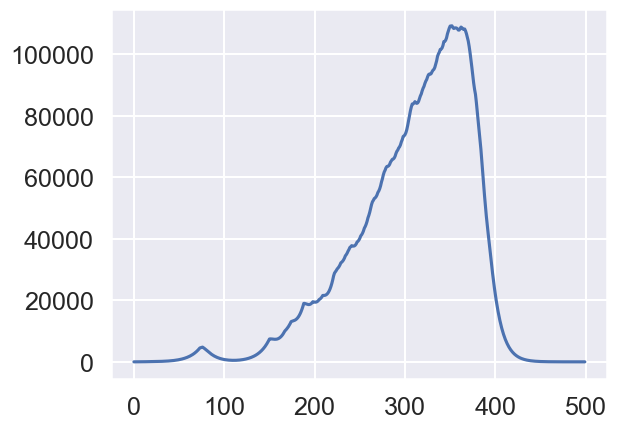

In [437]:
plt.plot([(np.sum(i[0] + i[1])) for i in dis_a])

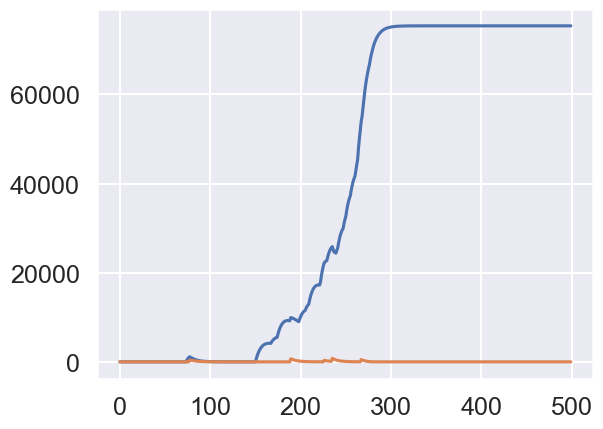

In [423]:
plt.plot([np.sum(i[0]) for i in dist_t])
plt.plot([np.sum(i[1]) for i in dist_t])

In [322]:
a, c = metpop.daur_dist
total = np.sum(a) + np.sum(c)

In [323]:
r_dist = metpop.r_dist

In [324]:
r_dist_n = 1 - np.divide(r_dist, 1000.)

<Axes: >

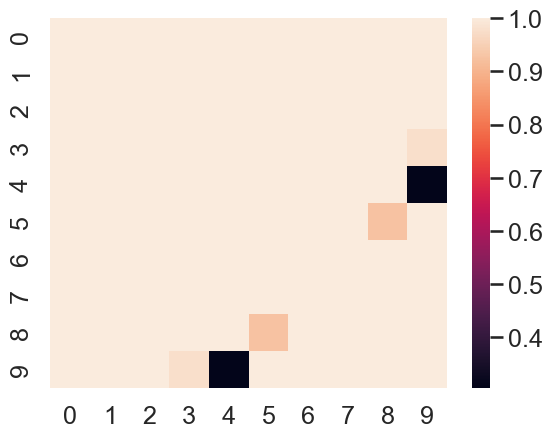

In [326]:
sns.heatmap(r_dist_n)

In [289]:
transit = 0.1 * correlate2d(r_dist_n, metpop.kernel, mode='same', boundary='symm')

In [293]:
transit

array([[-0.2,  0.1,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0.1,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ]])

In [291]:
  
    def diffuse_dauer(self):
        a, c = self.daur_dist
        total = np.sum(a) + np.sum(c)
        if total >= 0:
            total_a = np.sum(a)
            total_c = np.sum(c)
            if total_a > 0:
                f_a = np.divide(a, total)
                diff_state_a = self.r_rate * correlate2d(f_a, self.kernel, mode='same', boundary='symm')
                f_a += diff_state_a
                f_a = total_a * f_a
                for i in self.index:
                    self.metapop[i].pop[2][0]  = f_a[i[0]][i[1]]
            if total_c > 0:
                f_c = np.divide(c, total)
                diff_state_c = self.r_rate * correlate2d(f_c, self.kernel, mode='same', boundary='symm')
                f_c += diff_state_c
                f_c = total_c * f_c
                for i in self.index:
                    self.metapop[i].pop[12][0] = f_c[i[0]][i[1]]
                    
    def diffuse_dauer_r(self):
        a, c = self.daur_dist
        total = np.sum(a) + np.sum(c)
        if total >= 0:
            r_dist_n = 1 - np.divide(self.r_dist, 1000.)
            diff_state_a = self.r_rate * correlate2d(r_dist_n, self.kernel, mode='same', boundary='symm')

array([[1263.70051432,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0

In [341]:
d_n = np.random.randint(0, 100, (3, 3))

In [346]:
r = np.array([[0, 0, 0],
              [0, 1, 1],
              [0, 0, 1]])

In [353]:
transit = 0.1 * correlate2d(1- r, metpop.kernel, mode='same', boundary='symm')

In [356]:
transit

array([[ 0. , -0.1, -0.1],
       [-0.1,  0.3,  0.1],
       [ 0. , -0.2,  0.1]])

In [357]:
np.sum(d_n)

1.0

In [360]:
d_n + transit

array([[ 0.10536398, -0.01187739, -0.04252874],
       [ 0.03793103,  0.44942529,  0.22068966],
       [ 0.07662835, -0.11187739,  0.27624521]])

In [361]:
d_n

array([[0.10536398, 0.08812261, 0.05747126],
       [0.13793103, 0.14942529, 0.12068966],
       [0.07662835, 0.08812261, 0.17624521]])

In [342]:
total = np.sum(d_n)

In [343]:
d_n = np.divide(d_n, total)

In [344]:
d_n

array([[0.10536398, 0.08812261, 0.05747126],
       [0.13793103, 0.14942529, 0.12068966],
       [0.07662835, 0.08812261, 0.17624521]])

<Axes: >

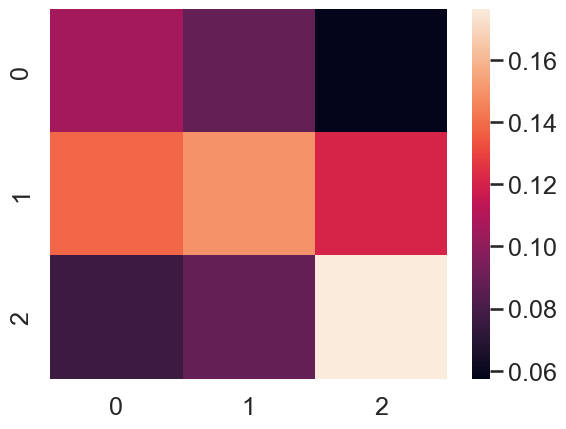

In [345]:
sns.heatmap(d_n)

In [30]:
metpop = MetaPopulation(4, 0.0, 0.01, r_rate=0.1)

In [31]:
metpop.set_diet_comp('OP50')

In [32]:
metpop.fill_pop()

In [33]:
metpop.add_pop((0,0), 'A')
metpop.add_pop((3,3), 'A')
metpop.add_pop((0,3), 'A')
metpop.add_pop((3,0), 'A')

In [34]:
dist_t = []
dis_a = []
for i in range(200):
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    t1, t2 = metpop.ra_dist
    # f_a = np.sum(t1)/np.sum(t1 + t2)
    dist_t.append((a, b))
    # dis_a.append((f_a, np.sum(t1)))
    dis_a.append((t1, t2))
    metpop.diffuse_dauer()

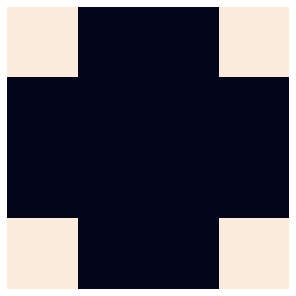

In [35]:
fig, ax = plt.subplots(
nrows=1,
ncols=1,
figsize=(4, 4),
constrained_layout=True)

sns.heatmap(dis_a[50][0], ax = ax, cbar=False)
# sns.heatmap(dis_a[100][1], ax = ax, cbar=False)

ax.set(yticks=[], xticks=[])

plt.savefig('./figures/loc_icon.pdf', bbox_inches='tight', dpi=300)

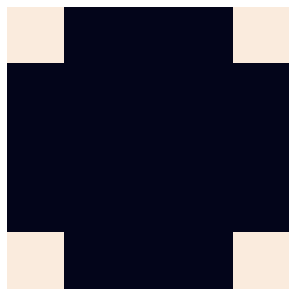

In [16]:
fig, ax = plt.subplots(
nrows=1,
ncols=1,
figsize=(4, 4),
constrained_layout=True)

sns.heatmap(dis_a[50][0], ax = ax, cbar=False)
# sns.heatmap(dis_a[100][1], ax = ax, cbar=False)

ax.set(yticks=[], xticks=[])

plt.savefig('./figures/diffusion.pdf', bbox_inches='tight', dpi=300)

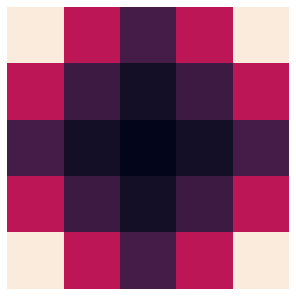

In [20]:
fig, ax = plt.subplots(
nrows=1,
ncols=1,
figsize=(4, 4),
constrained_layout=True)

sns.heatmap(dis_a[98][0], ax = ax, cbar=False)
# sns.heatmap(dis_a[100][1], ax = ax, cbar=False)

ax.set(yticks=[], xticks=[])

plt.savefig('./figures/diffusion_2.pdf', bbox_inches='tight', dpi=300)

KeyboardInterrupt: 

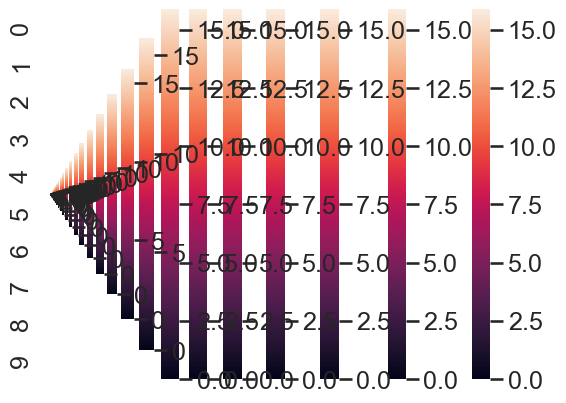

In [271]:
for i in range(100):
    sns.heatmap(dis_a[17][0])

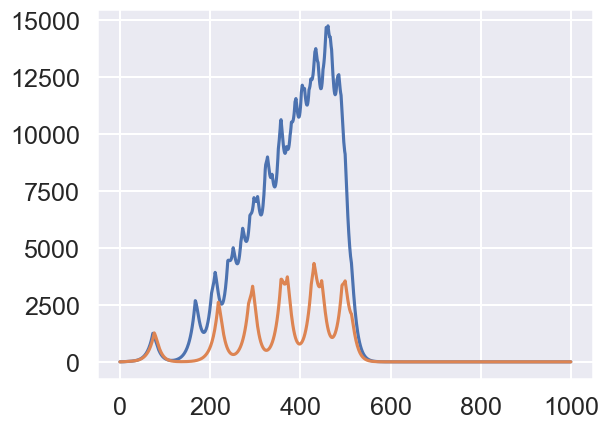

In [163]:
plt.plot([np.sum(i[0]) for i in dis_a])
plt.plot([np.sum(i[1]) for i in dis_a])

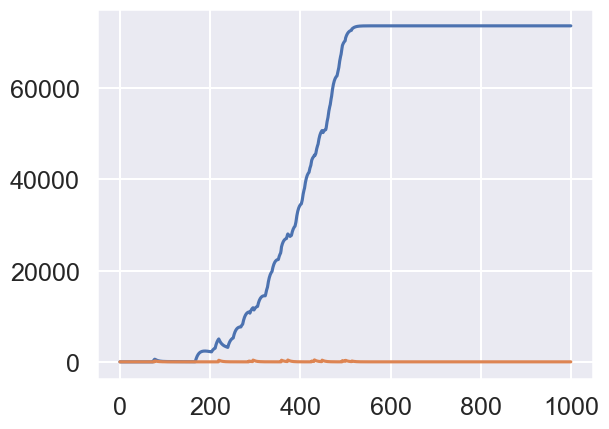

In [166]:
plt.plot([np.sum(i[0]) for i in dist_t])
plt.plot([np.sum(i[1]) for i in dist_t])


# diffusion tests

In [30]:
metpop = MetaPopulation(10, 0.0, 0.01, r_rate=0.1)

metpop.set_diet_comp('OP50')

metpop.fill_pop()

metpop.add_pop((5,5), 'A')

In [31]:
dist_t = []
dis_a = []
for i in range(400):
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    t1, t2 = metpop.ra_dist
    # f_a = np.sum(t1)/np.sum(t1 + t2)
    dist_t.append((a, b))
    # dis_a.append((f_a, np.sum(t1)))
    dis_a.append((t1, t2))
    metpop.diffuse_dauer()

[[], []]

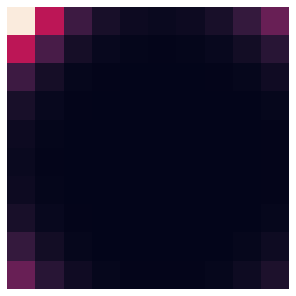

In [32]:
fig, ax = plt.subplots(
nrows=1,
ncols=1,
figsize=(4, 4),
constrained_layout=True)

sns.heatmap(dis_a[399][0], ax = ax, cbar=False)
# sns.heatmap(dis_a[100][1], ax = ax, cbar=False)

ax.set(yticks=[], xticks=[])

In [33]:
metpop.reset_food()

In [34]:
dist_t = []
dis_a = []
for i in range(100):
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    t1, t2 = metpop.ra_dist
    # f_a = np.sum(t1)/np.sum(t1 + t2)
    dist_t.append((a, b))
    # dis_a.append((f_a, np.sum(t1)))
    dis_a.append((t1, t2))
    metpop.diffuse_dauer()

[[], []]

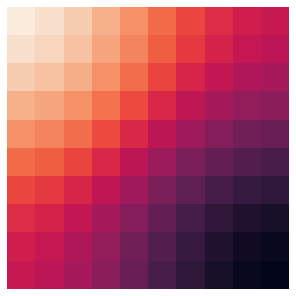

In [40]:
fig, ax = plt.subplots(
nrows=1,
ncols=1,
figsize=(4, 4),
constrained_layout=True)

sns.heatmap(dis_a[99][0], ax = ax, cbar=False)
# sns.heatmap(dis_a[100][1], ax = ax, cbar=False)

ax.set(yticks=[], xticks=[])